In [68]:
!python -V

Python 3.13.2


In [69]:
# !conda install pandas seaborn matplotlib scikit-learn pyarrow

In [70]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

In [71]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')

# Q1. Downloading the data
print(f"Number of columns in the dataset: {df.shape[1]}")

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

# Q2. Computing duration
std_duration = df.duration.std()
print(f"Standard deviation of trip durations: {std_duration:.2f} minutes")

#Q3. Dropping outliers
# Save total before filtering
total_before = len(df)
df = df[(df.duration >= 1) & (df.duration <= 60)]
# Save total after filtering
total_after = len(df)
# Calculate fraction
fraction = total_after / total_before
print(f"Fraction of records kept after removing outliers: {fraction:.3f}")

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

Number of columns in the dataset: 19
Standard deviation of trip durations: 42.59 minutes
Fraction of records kept after removing outliers: 0.981


/tmp/ipykernel_18903/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_18903/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


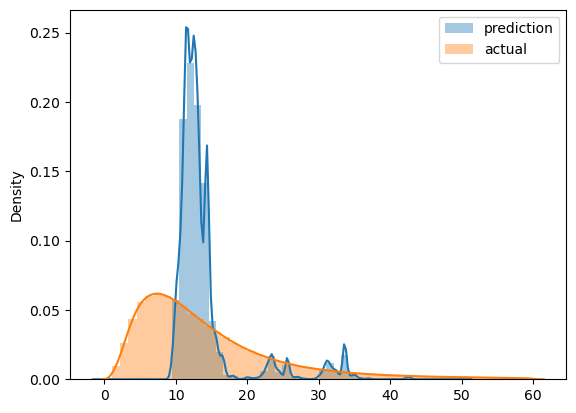

In [72]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [73]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
        
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [74]:
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

In [75]:
len(df_train), len(df_val)

(3009173, 2855951)

In [76]:
# Step 1: Use only the pickup and dropoff location IDs
categorical = ['PULocationID', 'DOLocationID']

# Step 2: Turn the dataframe into a list of dictionaries
train_dicts = df_train[categorical].to_dict(orient='records')
val_dicts = df_val[categorical].to_dict(orient='records')

# Step 3: Fit the DictVectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Step 4: Print the shape (rows, columns)
print(f"Train Feature matrix shape: {X_train.shape}")
print(f"Dimensionality (number of columns): {X_train.shape[1]}")

print(f"Val Feature matrix shape: {X_val.shape}")
print(f"Dimensionality (number of columns): {X_val.shape[1]}")

Train Feature matrix shape: (3009173, 515)
Dimensionality (number of columns): 515
Val Feature matrix shape: (2855951, 515)
Dimensionality (number of columns): 515


In [77]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [78]:
# Q5. Training a model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
print(f"Train RMSE: {rmse_train:.2f}")

# Q6. Evaluating the model
y_pred_val = lr.predict(X_val)
rmse_val = root_mean_squared_error(y_val, y_pred_val)
print(f"Validation RMSE: {rmse_val:.2f}")


Train RMSE: 7.65
Validation RMSE: 7.81


In [79]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)